<a href="https://colab.research.google.com/github/BBotond03/SkinCancerDetection/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script for Downloading the Data
1. We download the data  through the Kaggle API (for this we will have to provide out personal API key, this can be found at Kaggle profile settings).
2. Extract the downloaded zip file

In [ ]:
#to be able to download the dataset to our current runtime
!pip install kaggle

In [ ]:
from google.colab import files

# Upload the file
uploaded = files.upload()

# Get the actual file name from the dictionary
file_name = list(uploaded.keys())[0]
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Save the API key securely without displaying it
with open('/root/.kaggle/kaggle.json', 'wb') as f:
    f.write(uploaded[file_name])

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json


Saving kaggle (2).json to kaggle (2).json
cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle competitions download -c isic-2024-challenge

 99% 1.99G/2.00G [00:27<00:00, 177MB/s]
100% 2.00G/2.00G [00:27<00:00, 78.9MB/s]


In [ ]:
import zipfile
import os

# Path to your zip file and extract location
zip_file_path = 'isic-2024-challenge.zip'
extract_to_path = 'data'

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
    print("Extraction completed.")

Extraction completed.


# Data Preproccessing

In [ ]:
!pip install tensorflow

In [ ]:
#neccesary imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_datasets as tfds
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample


In [ ]:
import os
import cv2

# Load CSV
csv_path = './data/train-metadata.csv'
df = pd.read_csv(csv_path, low_memory=False)

# Append '.jpg' to each isic_id to match image filenames
df['isic_id'] = df['isic_id'].astype(str) + '.jpg'

# Directory where images are stored
img_dir = './data/train-image/image'  # Ensure this path is correct

# Filter for files that actually exist
df['filepath'] = df['isic_id'].apply(lambda x: os.path.join(img_dir, x))
df = df[df['filepath'].apply(os.path.exists)]

# Print out a summary
print(f"Number of valid images after filtering: {len(df)}")
print(df[['isic_id', 'filepath']].head())  # Optional: to verify paths

# target contains the diagnosis
df['target'] = df['target'].astype(int)

# Now we separate a untouched dataset for testing with 50 images, 15 infected and 35 uninfected
# This is needed to be filtered since in the original dataset we have much fewer uninfected lesions
# Separate the data into two groups: infected and uninfected
infected_df = df[df['target'] == 1]
uninfected_df = df[df['target'] == 0]

# Randomly select 15 infected lesions and 35 uninfected lesions for the test set
test_infected = infected_df.sample(n=15, random_state=42)
test_uninfected = uninfected_df.sample(n=35, random_state=42)

# Combine the test set
test_df = pd.concat([test_infected, test_uninfected]).reset_index(drop=True)

# Exclude the test set from the main dataset
df = df[~df['isic_id'].isin(test_df['isic_id'])].reset_index(drop=True)

# Print out the summary of the test set
print(f"Test Set Size: {len(test_df)}")
print(test_df['target'].value_counts())
print(test_df.head())  # Optional: inspect the test set

# Because the dataset is highly imbalanced we decided to upsample the infected data
# and downsample the uninfected data

# Check how it looks like before changing
print("Class Distribution Before Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

df_majority = df.query("target==0").sample(frac=0.01, random_state=42)
df_minority = df.query("target==1").sample(frac=5.0, replace=True, random_state=42)
df = pd.concat([df_majority, df_minority], axis=0).sample(frac=1.0)

# Check after changing
print("\nCalss Distribution After Sampling (%):")
display(df.target.value_counts(normalize=True)*100)

Number of valid images after filtering: 401059
            isic_id                                   filepath
0  ISIC_0015670.jpg  ./data/train-image/image/ISIC_0015670.jpg
1  ISIC_0015845.jpg  ./data/train-image/image/ISIC_0015845.jpg
2  ISIC_0015864.jpg  ./data/train-image/image/ISIC_0015864.jpg
3  ISIC_0015902.jpg  ./data/train-image/image/ISIC_0015902.jpg
4  ISIC_0024200.jpg  ./data/train-image/image/ISIC_0024200.jpg
Test Set Size: 50
target
0    35
1    15
Name: count, dtype: int64
            isic_id  target  patient_id  age_approx     sex  \
0  ISIC_1885694.jpg       1  IP_2456971        60.0    male   
1  ISIC_6776067.jpg       1  IP_1907604        55.0    male   
2  ISIC_6242031.jpg       1  IP_2084621        80.0    male   
3  ISIC_1164461.jpg       1  IP_3371534         NaN     NaN   
4  ISIC_9877311.jpg       1  IP_4717387        50.0  female   

  anatom_site_general  clin_size_long_diam_mm          image_type  \
0           head/neck                    2.70  TBP tile: clo

,proportion
target,
0,99.905738
1,0.094262



Calss Distribution After Sampling (%):


,proportion
target,
0,67.944369
1,32.055631


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Because there is still an imbalance we can define class weights
# This cponsiders the minority class with higher weights and the majority with smaller weights
class_weights = compute_class_weight('balanced', classes=np.unique(df['target']), y=df['target'])
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 0.7358961557663505, 1: 1.5597883597883597}


In [ ]:
from sklearn.model_selection import train_test_split

# Split the remaining data into train and validation datasets

# Ensure the test set is excluded
assert not df['isic_id'].isin(test_df['isic_id']).any(), "Test data overlaps with train/validation data!"

# 80% train 20% validation
training_df, validation_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['target'],  # Ensure stratification to balance classes
    random_state=42
)

# Print out the sizes and class distributions
print(f"# Num Train: {len(training_df)} | Num Valid: {len(validation_df)}")
print("\nTraining Set Class Distribution (%):")
print(training_df['target'].value_counts(normalize=True) * 100)

print("\nValidation Set Class Distribution (%):")
print(validation_df['target'].value_counts(normalize=True) * 100)

# Num Train: 4716 | Num Valid: 1180

Training Set Class Distribution (%):
target
0    67.938931
1    32.061069
Name: proportion, dtype: float64

Validation Set Class Distribution (%):
target
0    67.966102
1    32.033898
Name: proportion, dtype: float64


In [ ]:
!pip install albumentations

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import numpy as np
import cv2
import tensorflow as tf
import math

# Create a class for data augmentation and preprocess train and validation datasets

# Define image size and batch size
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

# Define the augmentation pipeline
aug = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomResizedCrop(width=IMG_SIZE[0], height=IMG_SIZE[1], scale=(0.8, 1.0), p=1)
])

# Class for generating batches of images with optional augmentations
class AlbumentationsImageGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, img_size, aug=None, shuffle=True):
        # Initialize the generator with the given parameters
        self.dataframe = dataframe                # DataFrame containing image paths and labels
        self.batch_size = batch_size              # Number of images per batch
        self.img_size = img_size                  # Size to which images will be resized (width, height)
        self.aug = aug                            # Augmentation function to apply to images (optional)
        self.shuffle = shuffle                    # Whether to shuffle data after each epoch
        self.image_paths = dataframe['filepath'].values  # Extract image file paths from the DataFrame
        self.labels = dataframe['target'].values  # Extract labels from the DataFrame
        self.indexes = np.arange(len(self.image_paths))  # Create an array of indexes for the images
        self.on_epoch_end()                       # Shuffle the data if required

    def __len__(self):
        # Return the number of batches per epoch
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        # Shuffle the indexes if shuffling is enabled
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # Calculate the start and end index for the current batch
        start_index = index * self.batch_size
        end_index = min((index + 1) * self.batch_size, len(self.image_paths))
        batch_indexes = self.indexes[start_index:end_index]

        # Initialize lists to hold the images and labels for the current batch
        batch_images = []
        batch_labels = self.labels[batch_indexes]

        # Process each image in the batch
        for idx in batch_indexes:
            # Read the image from the file
            image = cv2.imread(self.image_paths[idx])
            # Convert the image from BGR to RGB format
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Apply augmentations if provided
            if self.aug:
                image = self.aug(image=image)['image']

            # Resize the image to the specified size
            image = cv2.resize(image, (self.img_size[0], self.img_size[1]))
            # Add the processed image to the batch
            batch_images.append(image)

        # Normalize the images to the range [0, 1]
        batch_images = np.array(batch_images) / 255.0

        # Return the processed batch of images and corresponding labels
        return batch_images, batch_labels

# Generate training data
train_gen = AlbumentationsImageGenerator(
    dataframe=training_df,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    aug=aug
)

# Generate validation data
# For validation no augmentation nor shuffleing is enabled to not produce invalid accuracy
val_gen = AlbumentationsImageGenerator(
    dataframe=validation_df,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    aug=None,  # No augmentations for validation
    shuffle=False
)

# Generator wrapper
def train_gen_callable():
    for i in range(len(train_gen)):
        yield train_gen[i]

def val_gen_callable():
    for i in range(len(val_gen)):
        yield val_gen[i]

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    train_gen_callable,
    output_signature=(
        tf.TensorSpec(shape=(None, *IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
).repeat() # This can be repeated since augmentation is applied

val_dataset = tf.data.Dataset.from_generator(
    val_gen_callable,
    output_signature=(
        tf.TensorSpec(shape=(None, *IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)


# Calculate steps per epoch using math.ceil
# -1 is to ensure we get complete batches
train_steps_per_epoch = math.ceil(len(training_df) / BATCH_SIZE)-1
val_steps_per_epoch = int((math.ceil(len(validation_df) / BATCH_SIZE)-1))


# Print details for confirmation
print(f"Training data: {len(training_df)} samples")
print(f"Validation data: {len(validation_df)} samples")
print(f"Train steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps per epoch: {val_steps_per_epoch}")


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.24 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Training data: 4716 samples
Validation data: 1180 samples
Train steps per epoch: 147
Validation steps per epoch: 36


In [ ]:
!pip install tqdm

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from sklearn.utils import class_weight
from tensorflow.keras.regularizers import l2
from tqdm.keras import TqdmCallback
from tensorflow.keras.optimizers.schedules import CosineDecay


In [ ]:
# Define number of epochs
EPOCHS = 32

# Initialize the InceptionV3 model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze base model

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=output)

# Define CosineDecay learning rate schedule
lr_schedule = CosineDecay(
    initial_learning_rate=0.0001,  # Starting learning rate
    decay_steps=10000,            # Number of steps for decay
    alpha=0.1                     # Final learning rate as a fraction of the initial rate
)

# Compile the model
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

# Calculate class weights
labels = df['target'].astype(int).values  # Ensure target values are integers (0 or 1)


# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
model_checkpoint = ModelCheckpoint(
    filepath='best_melanoma_inceptionv3.keras',
    save_best_only=True,
    monitor='val_loss',
    mode='min',
    verbose=1
)
# If the model stops learning reduce the learning rate
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-7
)

# Train the model with class weights and callbacks
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler, TqdmCallback()],
)

# Load the best saved model
best_model = tf.keras.models.load_model('best_melanoma_inceptionv3.keras')

# Evaluate the best model on the validation set
loss, accuracy = best_model.evaluate(val_gen, steps=val_steps_per_epoch)
print(f"Best Model Validation Accuracy: {accuracy:.2f}")

tensorboard_callback = TensorBoard(log_dir="./logs", write_graph=True, histogram_freq=1)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 150, 150, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 74, 74, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 74, 74, 32)     │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 74, 74, 32)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 72, 72, 32)     │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 72, 72, 32)     │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 72, 72, 32)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 72, 72, 64)     │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 72, 72, 64)     │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 72, 72, 64)     │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 35, 35, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 35, 35, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 35, 35, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 35, 35, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 33, 33, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 33, 33, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 23,019,809 (87.81 MB)

 Trainable params: 1,215,233 (4.64 MB)

 Non-trainable params: 21,804,576 (83.18 MB)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/32
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5761 - loss: 13.8622
Epoch 1: val_loss improved from inf to 12.92811, saving model to best_melanoma_inceptionv3.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 115ms/step - accuracy: 0.5763 - loss: 13.8604 - val_accuracy: 0.7370 - val_loss: 12.9281 - learning_rate: 9.9952e-05
Epoch 2/32
146/147 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.6744 - loss: 12.8586

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 12.92811 to 11.96823, saving model to best_melanoma_inceptionv3.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.6744 - loss: 12.8557 - val_accuracy: 0.8571 - val_loss: 11.9682 - learning_rate: 9.9808e-05
Epoch 3/32
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6950 - loss: 12.0143
Epoch 3: val_loss improved from 11.96823 to 11.27416, saving model to best_melanoma_inceptionv3.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 8s 56ms/step - accuracy: 0.6951 - loss: 12.0129 - val_accuracy: 0.8090 - val_loss: 11.2742 - learning_rate: 9.9569e-05
Epoch 4/32
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7079 - loss: 11.2189
Epoch 4: val_loss improved from 11.27416 to 10.40164, saving model to best_melanoma_inceptionv3.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.7080 - loss: 11.2176 - val_accuracy: 0.8929 - val_loss: 10.4016 - learning_rate: 9.9234e-05
Epoch 5/32
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7320

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


36/36 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8923 - loss: 2.2622
Best Model Validation Accuracy: 0.89


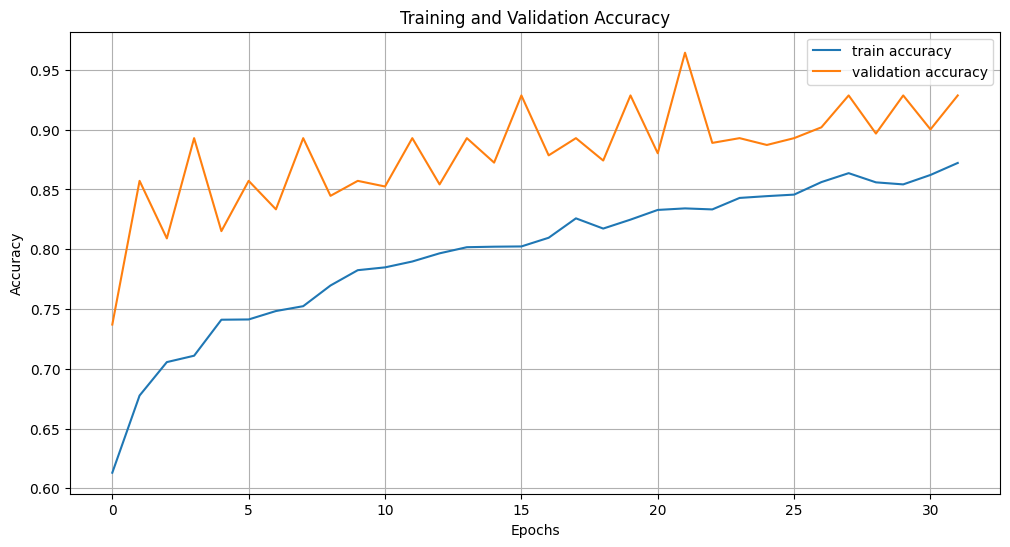

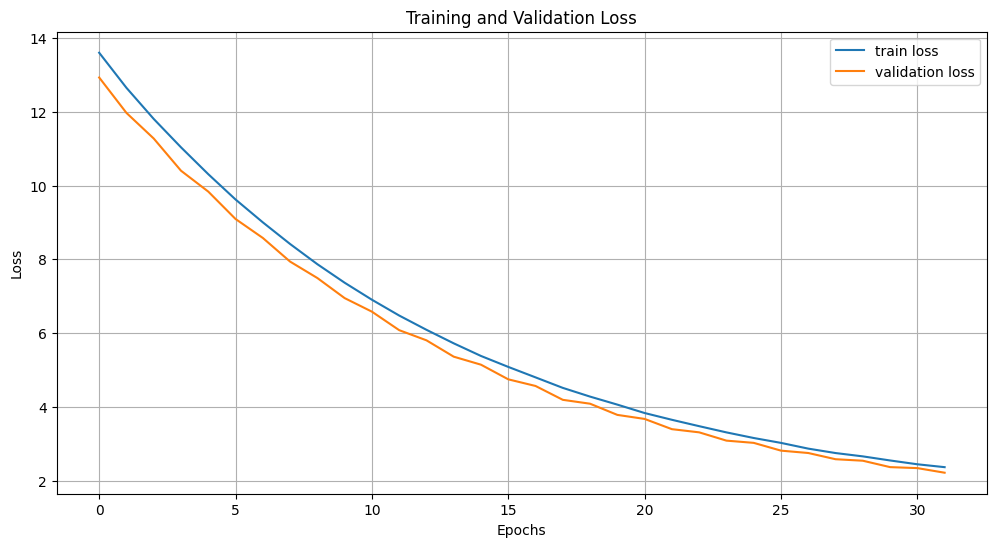

In [ ]:
import matplotlib.pyplot as plt

def plot_training(history):
    # Plot training accuracy and validation accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.plot(history.history['val_accuracy'], label='validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.grid(True)
    plt.show()

    # Plot training loss and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.grid(True)
    plt.show()

plot_training(history)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Optimize threshold based on F1 score
def optimize_threshold(y_pred_prob, y_true):
    best_f1 = 0
    best_threshold = 0
    for i in range(1000):
        threshold_temp = i / 1000
        y_pred = (y_pred_prob > threshold_temp).astype("int32").flatten()

        # Calculate metrics
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1_new = f1_score(y_true, y_pred, zero_division=0)

        if f1_new > best_f1:
            best_f1 = f1_new
            best_threshold = threshold_temp
    return best_threshold

# Get predictions and true labels
y_pred_prob = model.predict(val_gen)  # Predicted probabilities
y_true = np.concatenate([y for _, y in val_gen], axis=0).flatten()  # Flatten true labels

# Optimize threshold
threshold = optimize_threshold(y_pred_prob, y_true)

# Apply optimized threshold
y_pred = (y_pred_prob > threshold).astype("int32").flatten()

# Calculate confusion matrix and metrics
cm = confusion_matrix(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print metrics
print(f"Optimal Threshold: {threshold:.3f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1']).plot(
    cmap='Blues', ax=ax, colorbar=True
)

# Add title and metrics to the plot
plt.title('Confusion Matrix with Metrics')
plt.xlabel(f'Predicted Labels\n\nPrecision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}')
plt.ylabel('True Labels')
plt.show()


37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 402ms/step


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# ROC curve

# Get the predicted probabilities
y_pred_prob = model.predict(val_gen).flatten()  # Flatten to a 1D array

# Get the true labels from the validation generator
y_true = np.concatenate([y for x, y in val_gen], axis=0).flatten()  # Flatten for compatibility

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred_prob)

# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()



In [ ]:
# Test the model

# Define test generator without augmentations
test_gen = AlbumentationsImageGenerator(
    dataframe=test_df,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    aug=None,
    shuffle=False
)

# Test generator wrapper
def test_gen_callable():
    for i in range(len(test_gen)):
        yield test_gen[i]

# Convert to TensorFlow dataset
test_dataset = tf.data.Dataset.from_generator(
    test_gen_callable,
    output_signature=(
        tf.TensorSpec(shape=(None, *IMG_SIZE, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)


In [ ]:
# Evaluate the model
predictions = model.predict(test_dataset, steps=len(test_df) // BATCH_SIZE)

# Convert predictions to binary labels (0 or 1)
predicted_labels = (predictions > threshold).astype(int)


In [ ]:
import matplotlib.pyplot as plt
import cv2

# Define number of images to display
num_images_to_display = 50

# Select a subset of the test dataset
sample_images = test_df.sample(n=num_images_to_display, random_state=42)

# Set number of rows and columns (example: 2 rows, 5 columns)
num_columns = 5
num_rows = (num_images_to_display + num_columns - 1) // num_columns  # Round up for rows

# Create a figure for plotting the images
fig, axes = plt.subplots(num_rows, num_columns, figsize=(15, num_rows * 3))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Iterate through the sample images and plot them
for i, (idx, row) in enumerate(sample_images.iterrows()):
    image_path = row['filepath']
    actual_label = row['target']

    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

    # Get the prediction for the image
    predicted_label = predicted_labels[sample_images.index[i]]

    # Plot the image
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f"Pred: {predicted_label}\nActual: {actual_label}")

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score

# Predict probabilities for the entire test dataset
y_pred_prob = best_model.predict(test_dataset)
y_pred = (y_pred_prob > threshold).astype(int).flatten()

# Ensure true labels are extracted correctly from the test dataset
y_true = test_df['target'].values.flatten()

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Calculate metrics
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues', ax=ax, colorbar=False)

# Add title and metrics to the plot
plt.title('Confusion Matrix with Metrics')
plt.xlabel(f'Predicted Labels\n\nPrecision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}')
plt.ylabel('True Labels')
plt.show()


In [ ]:
# Download Keras tuner

!pip install keras-tuner

In [ ]:
import keras_tuner as kt

# Hyperparameter optimization

def build_model(hp):
    # Load InceptionV3 model as base
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
    base_model.trainable = False  # Freeze base model

    # Hyperparameters for dense layers and dropout
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(hp.Int('units_1', min_value=256, max_value=512, step=64), activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_1', min_value=0.3, max_value=0.5, step=0.1))(x)
    x = Dense(hp.Int('units_2', min_value=128, max_value=256, step=64), activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_2', min_value=0.3, max_value=0.5, step=0.1))(x)
    x = Dense(hp.Int('units_3', min_value=64, max_value=128, step=32), activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_3', min_value=0.3, max_value=0.5, step=0.1))(x)

    output = Dense(1, activation='sigmoid')(x) # Sigmoid for binary classification

    model = Model(inputs=base_model.input, outputs=output)

    # Learning rate optimization
    lr_schedule = CosineDecay(
        initial_learning_rate=hp.Float('lr', min_value=1e-5, max_value=1e-3, sampling='LOG'),
        decay_steps=10000,
        alpha=0.1
    )

    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
# Set the tuner

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    hyperband_iterations=2,
    directory='kt_dir',
    project_name='image_classification_tuning'
)


In [ ]:
# Perform hyperparameter optimization

tuner.search(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps_per_epoch,
    class_weight=class_weights,
    callbacks=[early_stopping]
)


In [ ]:
# Get the best model and its parameters

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hyperparameters.values)


In [ ]:
# Evaluate on test data

test_loss, test_accuracy = best_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")